# Candlesticks Analysis Part - 2

##### Real Trading is much different than trading on daily closing price positions, this Notebook only aims at building mindset of a quant trader

In [442]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt 

df = yf.download(tickers='AAPL',start='2018-01-01',end='2023-01-01')
print("Total number of data points are",len(df))
df.tail()

[*********************100%***********************]  1 of 1 completed
Total number of data points are 1259


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.477127,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.652435,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.674019,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.233658,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.552719,77034200


In [443]:
df.isna().sum()
df.reset_index(inplace=True)

In [444]:
# We can add multiple indicators using pandas_ta library.
df['ATR'] = df.ta.atr(length=10)
df['RSI'] = df.ta.rsi()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,ATR,RSI
1254,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.477127,63814900,4.373139,35.675357
1255,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.652435,69007800,4.249825,33.658569
1256,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.674019,85438400,4.340842,29.714325
1257,2022-12-29,127.989998,130.479996,127.730003,129.610001,129.233658,75703700,4.350758,36.845374
1258,2022-12-30,128.410004,129.949997,127.430000,129.929993,129.552719,77034200,4.167682,37.457887


In [445]:
#Defined on a candle of OHLC type that means its equivalent to a row dataframe 

def scan_Engulfing(dataframe):
    alpha= 1
    beta= 0.1
    gamma= 0.1                                                                  #  Parameter controlling filter for candlestick body existence 
    isEngulfing=[0]
    length  =  len(dataframe)
    close   =  dataframe['Close'].to_list()
    open    =  dataframe['Open'].to_list()
    body_differnce = [0] * (length)

    for candle in range(1,length):
        body_differnce[candle] = abs(open[candle]-close[candle])
        if body_differnce[candle]<1e-2:
            body_differnce[candle]=1e-2      

        body_difference_minimum = gamma   # Ensure existence of candle body
        if (body_differnce[candle]>body_difference_minimum and                  # Ensure existence of candle body
            body_differnce[candle-1]>body_difference_minimum and                # Ensure existence of candle body
            open[candle-1]<close[candle-1] and                                  # First candle Bullish
            abs(open[candle-1]-close[candle-1])>alpha and                       # First candle body should be greater than alpha points
            open[candle]>close[candle] and                                      # Second candle Bearish
            abs(open[candle]-close[candle])> alpha*1.5 and                      # Second candle body should be bigger than previous candle
            (open[candle]-close[candle-1])> beta and                            # Ensure Engulfing
            (close[candle]-open[candle-1])>beta) :
                isEngulfing.append(2)                                           # Bearish Engulfing

        elif(body_differnce[candle]>body_difference_minimum and                 # Ensure existence of candle body
            body_differnce[candle-1]>body_difference_minimum and                # Ensure existence of candle body
            open[candle-1]>close[candle-1] and                                  # First candle Bearish
            abs(open[candle-1]-close[candle-1])>alpha and                       # First candle body should be greater than alpha points
            open[candle]<close[candle] and                                      # Second candle Bullish
            abs(open[candle]-close[candle])> alpha*1.5 and                      # Second candle body should be bigger than previous candle
            (open[candle]-close[candle-1])< -beta and                           # Ensure Engulfing
            (close[candle]-open[candle-1])<-beta) :
                isEngulfing.append(1)  
        else:
            isEngulfing.append(0)

    return isEngulfing

df['is_engulfing']=scan_Engulfing(df)
df['is_engulfing'].value_counts()            # This show how many signal can be extracted form the dtaaframe given

0    1212
2      24
1      23
Name: is_engulfing, dtype: int64

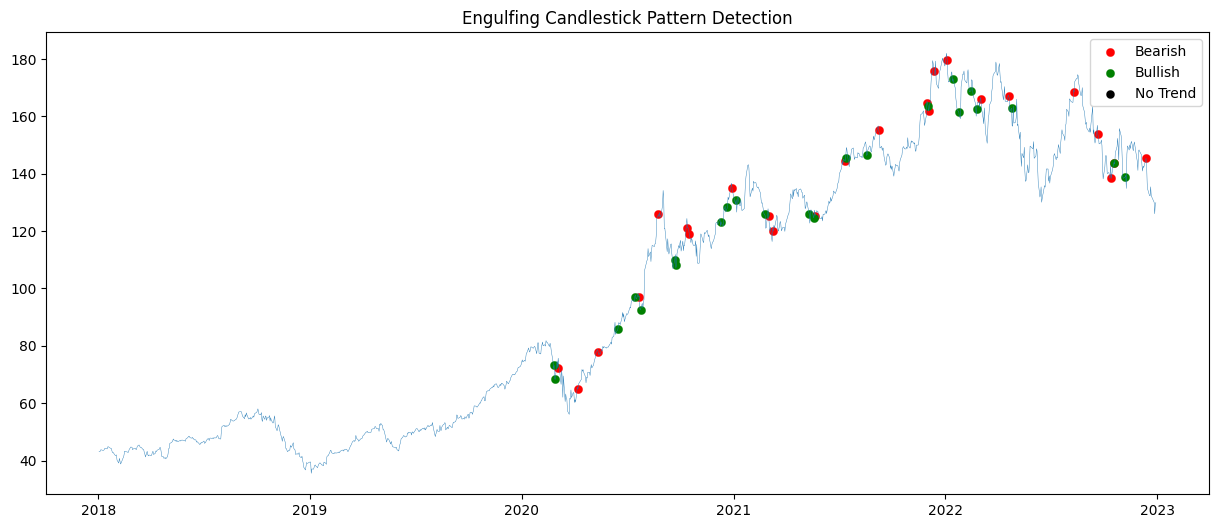

In [446]:
fig=plt.figure(figsize=[15,6])
plt.plot(df['Date'],df['Close'],lw=0.3)
plt.scatter(df['Date'].loc[df['is_engulfing']==2],df['Close'].loc[df['is_engulfing']==2],c='r',lw=0.2,label='Bearish')
plt.scatter(df['Date'].loc[df['is_engulfing']==1],df['Close'].loc[df['is_engulfing']==1],c='g',lw=0.2,label='Bullish')
plt.scatter(df['Date'].loc[df['is_engulfing']==3],df['Close'].loc[df['is_engulfing']==3],c='k',lw=0.1,label='No Trend')
plt.legend()
plt.title('Engulfing Candlestick Pattern Detection');

In [447]:
def scan_star_candlestick(dataframe):

    length = len(dataframe)
    high = dataframe['High'].to_list()
    low = dataframe['Low'].to_list()
    close = dataframe['Close'].to_list()
    open = dataframe['Open'].to_list()

    bodydiff = [0] * length

    highdiff = [0] * length
    lowdiff = [0] * length
    ratio1 = [0] * length
    ratio2 = [0] * length
    
    bodydiffmin = 0.0020

    star=[0]

    for candle in range(1,length):
        highdiff[candle] = high[candle]-max(open[candle],close[candle])
        lowdiff[candle] = min(open[candle],close[candle])-low[candle]
        bodydiff[candle] = abs(open[candle]-close[candle])
        if bodydiff[candle]<0.000001:
            bodydiff[candle]=0.000001
        ratio1[candle] = highdiff[candle]/bodydiff[candle]
        ratio2[candle] = lowdiff[candle]/bodydiff[candle]

        if (ratio1[candle]>5 and lowdiff[candle]<0.2*highdiff[candle] and bodydiff[candle]>bodydiffmin):# and open[candle]>close[candle]):
            star.append(2)
        elif (ratio2[candle]>5 and highdiff[candle]<0.2*lowdiff[candle] and bodydiff[candle]>bodydiffmin):# and open[candle]<close[candle]):
            star.append(1)
        else:
            star.append(0)
    return star


In [448]:
df['star']=scan_star_candlestick(df)
df['star'].value_counts()

0    1214
2      24
1      21
Name: star, dtype: int64

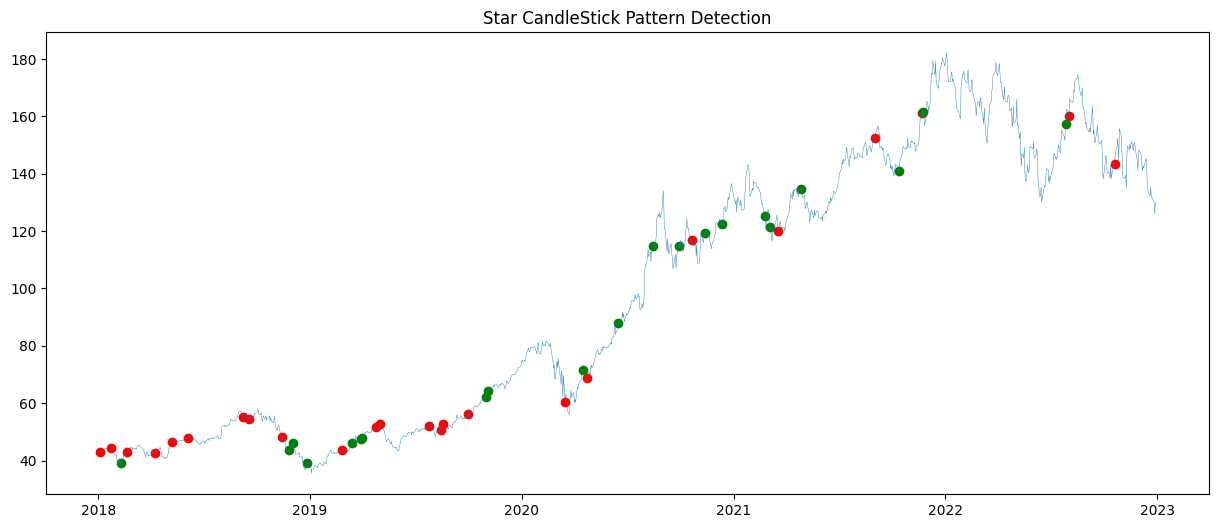

In [449]:
fig=plt.figure(figsize=[15,6])
plt.plot(df['Date'],df['Close'],lw=0.3)
plt.scatter(df['Date'].loc[df['star']==2],df['Close'].loc[df['star']==2],c='r',alpha=1)
plt.scatter(df['Date'].loc[df['star']==1],df['Close'].loc[df['star']==1],c='g',alpha=1)
# plt.scatter(df['Date'].loc[df['star']==0],df['Close'].loc[df['star']==0],c='k',alpha=0.1)
plt.title('Star CandleStick Pattern Detection');

In [450]:
def scan_direction(dataframe):
    close   =  dataframe['Close'].to_list()
    open    =  dataframe['Open'].to_list()
    length  =  len(dataframe)
    direction=[0]

    for candle in range(1,length):
        if (open[candle]<close[candle]):
            direction.append(1)
        elif (open[candle]>close[candle]):
            direction.append(2)
        else:
            direction.append(0)
    return direction

In [451]:
df['direction']=scan_direction(df)
df['direction'].value_counts()

1    663
2    591
0      5
Name: direction, dtype: int64

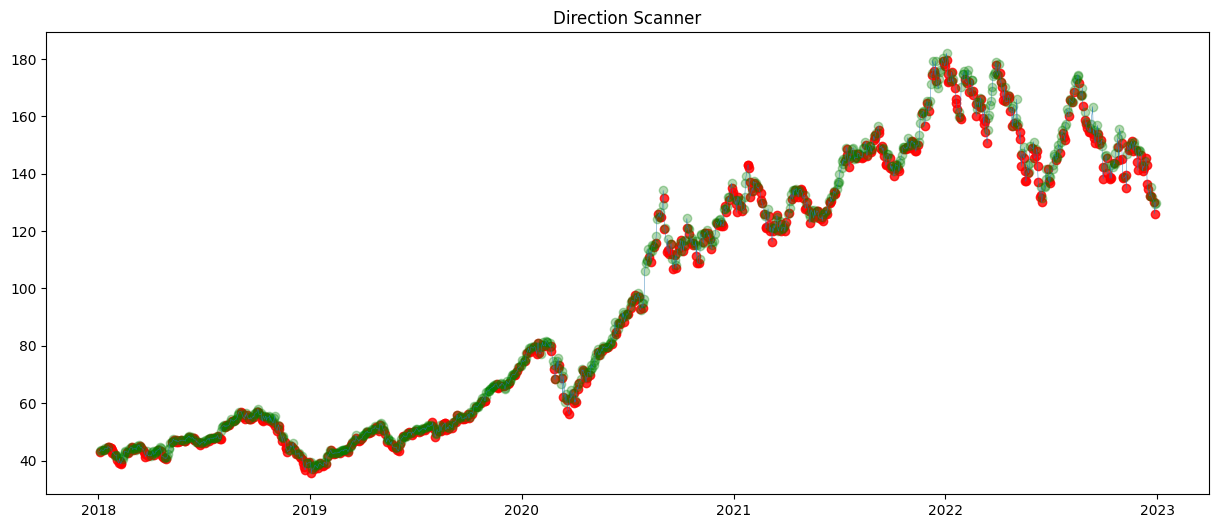

In [452]:
fig=plt.figure(figsize=[15,6])
plt.plot(df['Date'],df['Close'],lw=0.3)
plt.scatter(df['Date'].loc[df['direction']==2],df['Close'].loc[df['direction']==2],c='r',alpha=0.8)
plt.scatter(df['Date'].loc[df['direction']==1],df['Close'].loc[df['direction']==1],c='g',alpha=0.3)
# plt.scatter(df['Date'].loc[df['direction']==0],df['Close'].loc[df['direction']==0],c='k',alpha=0.1)
plt.title('Direction Scanner');

In [453]:
def trend_scanner(dataframe, look_ahead_window):
    length = len(dataframe)
    high = list(dataframe['High'])
    low = list(dataframe['Low'])
    close = list(dataframe['Close'])
    open = list(dataframe['Open'])
    category = [None] * length
    
    y_delta  = 5
    for line in range (0, length-1-look_ahead_window):
        for i in range(1,look_ahead_window+1):
            if( ((high[line+i]-close[line])>y_delta ) and ((close[line]-low[line+i])>y_delta ) ):
                category[line] = 0 # no trend
                break
            elif(close[line]-low[line+i])>y_delta :
                category[line] = 2 #downtrend
                break
            elif ((high[line+i]-close[line])>y_delta ):
                category[line] = 1 # uptrend
                break
            else:
                category[line] = 0 # no clear trend  
    return category

df['Trend'] = trend_scanner(df,20)
#df.head(30)

In [454]:
# df.reset_index(inplace=True)
df['Trend'].value_counts()

1.0    556
2.0    383
0.0    299
Name: Trend, dtype: int64

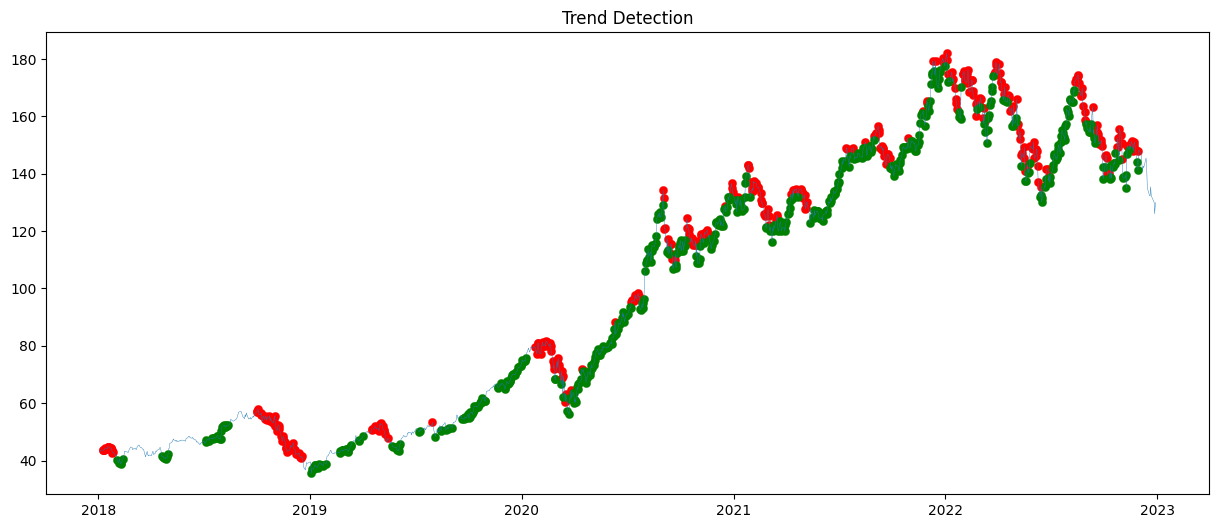

In [455]:
fig=plt.figure(figsize=[15,6])
plt.plot(df['Date'],df['Close'],lw=0.3)
plt.scatter(df['Date'].loc[df['Trend']==2],df['Close'].loc[df['Trend']==2],c='r',lw=0.2)
plt.scatter(df['Date'].loc[df['Trend']==1],df['Close'].loc[df['Trend']==1],c='g',lw=0.2)
# plt.scatter(df['Date'].loc[df['Trend']==3],df['Close'].loc[df['Trend']==3],c='k',lw=0.2)
plt.title('Trend Detection');

#### Signal Generation from all the indicators 

In [456]:
def Revsignal(dataframe):
    signal = [0] * len(dataframe)
    length = len(dataframe)
    
    for candle in range(1, length):
        if ((scan_Engulfing(dataframe)[candle]!=1 and trend_scanner(dataframe,3)[candle]!=1) and df.RSI[candle]<40):
            signal[candle] = -1
        elif((scan_Engulfing(dataframe)[candle]!=2 and trend_scanner(dataframe,3)[candle]!=2)  and df.RSI[candle]>60):
            signal[candle] = 1
        else:
            signal[candle] = 0
    return signal

df['signal'] = Revsignal(df)


In [457]:
#df.reset_index(drop=True, inplace=True)
(df['signal']).value_counts()

 0    717
 1    416
-1    126
Name: signal, dtype: int64

In [458]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,ATR,RSI,is_engulfing,star,direction,Trend,signal
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.831585,102223600,NaN,NaN,0,0,0,0.0,0
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.824478,118071600,NaN,NaN,0,2,2,0.0,0
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.014107,89738400,NaN,NaN,0,0,1,0.0,0
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.481060,94640000,NaN,NaN,0,0,1,0.0,0
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.326992,82271200,NaN,NaN,0,0,0,2.0,0
5,2018-01-09,43.637501,43.764999,43.352501,43.582500,41.322254,86336000,NaN,NaN,0,0,2,2.0,0
6,2018-01-10,43.290001,43.575001,43.250000,43.572498,41.312775,95839600,NaN,NaN,0,0,1,2.0,0
7,2018-01-11,43.647499,43.872501,43.622501,43.820000,41.547432,74670800,NaN,NaN,0,0,1,2.0,0
8,2018-01-12,44.044998,44.340000,43.912498,44.272499,41.976467,101672400,NaN,NaN,0,0,1,2.0,0
9,2018-01-16,44.474998,44.847500,44.035000,44.047501,41.763138,118263600,NaN,NaN,0,0,2,2.0,0


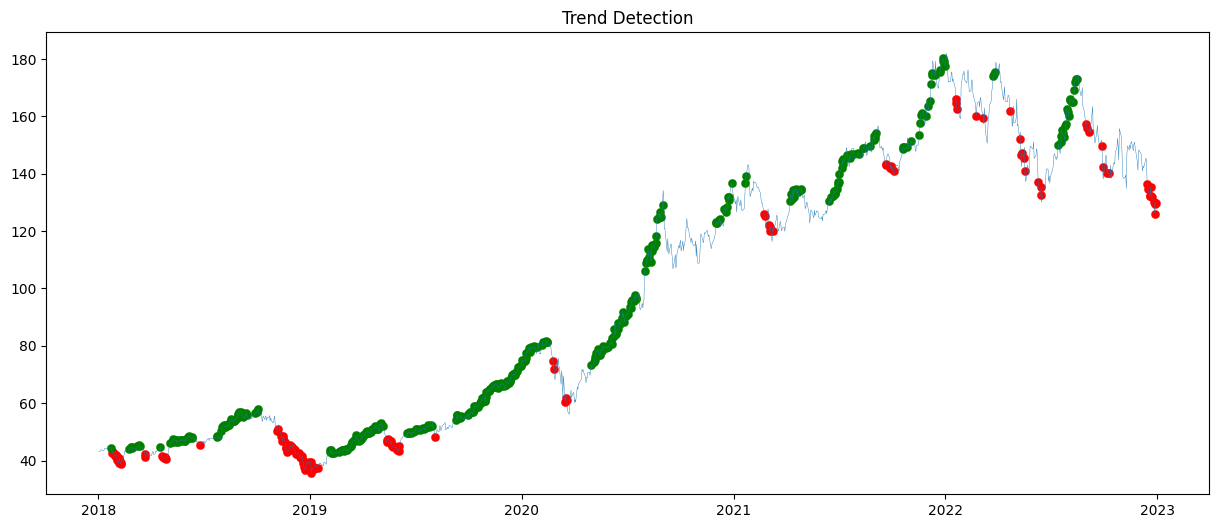

In [459]:
fig=plt.figure(figsize=[15,6])
plt.plot(df['Date'],df['Close'],lw=0.3)
plt.scatter(df['Date'].loc[df['signal']==-1],df['Close'].loc[df['signal']==-1],c='r',lw=0.2)
plt.scatter(df['Date'].loc[df['signal']==1],df['Close'].loc[df['signal']==1],c='g',lw=0.2)
plt.title('Trend Detection');

C:\Users\paras\AppData\Local\Temp\ipykernel_14996\2440387477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["signal"].loc[df['signal']==-1]=0


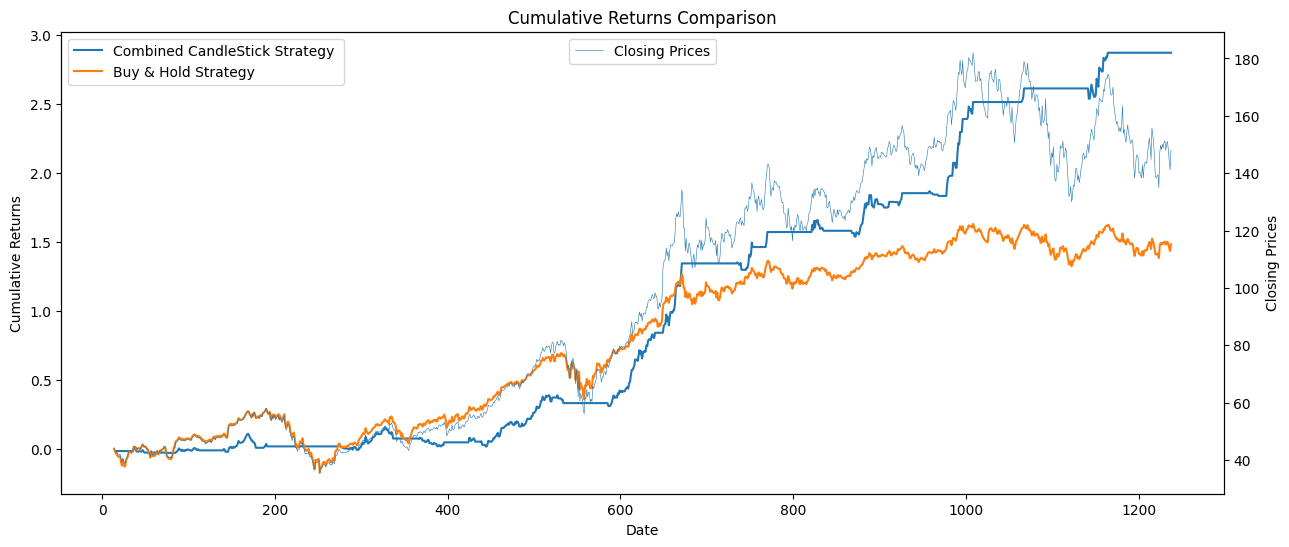

In [460]:
# Calculate the daily returns
df["Returns"] = df["Close"].pct_change()
df.dropna(inplace=True)
# Calculate the strategy returns
df["signal"].loc[df['signal']==-1]=0
df["Long_StrategyReturns"] = df["signal"].shift(1) * df["Returns"]
# Calculate the cumulative returns
df["CumulativeReturns"] = (1 + df["Long_StrategyReturns"]).cumprod() - 1
# Calculate the buy-and-hold returns
df["BuyHoldReturns"] = df["Returns"].cumsum()
# Plotting the cumulative returns
fig,ax = plt.subplots(figsize=(15, 6))
ax.plot(df.index, df["CumulativeReturns"], label="Combined CandleStick Strategy ")
ax.plot(df.index, df["BuyHoldReturns"], label="Buy & Hold Strategy ")
ax.set_title("Cumulative Returns Comparison")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns")

ax2=ax.twinx()
ax2.plot(df.index,df['Close'],label="Closing Prices",lw=0.4)
ax2.set_ylabel("Closing Prices",fontsize=10)
ax2.legend(loc='upper center')
ax.legend()
plt.show()